# Amazon Customer Reviews Dataset
Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazon’s iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. Over 130+ million customer reviews are available to researchers as part of this dataset.

### Documentation: 
https://s3.amazonaws.com/amazon-reviews-pds/readme.html

### List of databases link: 
https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt

### Database's link: 
https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_UK_v1_00.tsv.gz

In [2]:
import numpy as np
import pandas as pd
import datetime

In [3]:
PATH_DATA = "V:/Programmazione/Amazon/"

We recognize that we have some data which are "corrupted". For those data we are goning to set the date to 1900-01-01. Then we are going to delete them.

In [4]:
def parserDate(x):
    try:
        return datetime.datetime.strptime(x, '%Y-%m-%d')
    except ValueError:
        return datetime.datetime.strptime("1900-01-01", '%Y-%m-%d')

In [5]:
df =  pd.read_csv(
    "%sdata.tsv" % PATH_DATA, 
    encoding="utf-8", 
    header=0,
    sep='\t',
    usecols=['review_id','customer_id', 'product_id', 'product_title','product_category','star_rating','helpful_votes','total_votes','verified_purchase','review_headline','review_body','review_date'],
    index_col = 'review_id',
    dtype = {
        #'marketplace':str,
        'customer_id':str,
        'review_id':str,
        'product_id':str,
        #'product_parent':str,
        'product_title':str,
        'product_category':str,
        'star_rating': np.uint8,
        'helpful_votes': np.uint16,
        'total_votes': np.uint16,
        #'vine':str,
        'verified_purchase':bool,
        'review_headline':str,
        'review_body':str,
        },
    parse_dates = ['review_date'],
    true_values = ["Y"],
    false_values  = ["N"],
    skipinitialspace = True,
    date_parser=parserDate,
    infer_datetime_format = True,
    error_bad_lines = False,
    warn_bad_lines = True,
    engine='c',
    )

In [6]:
df.head()

,customer_id,product_id,product_title,product_category,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date
review_id,,,,,,,,,,,
R2YVNBBMXD8KVJ,10349,B00MWK7BWG,My Favourite Faded Fantasy,Music,5,0,0,True,Five Stars,The best album ever!,2014-12-29
R2K4BOL8MN1TTY,10629,B006CHML4I,Seiko 5 Men's Automatic Watch with Black Dial ...,Watches,4,0,0,True,Great watch from casio.,What a great watch. Both watches and strap is ...,2013-10-24
R3P40IEALROVCH,12136,B00IIFCJX0,Dexter Season 8,Digital_Video_Download,5,0,0,True,fantastic,"love watching all the episodes of Dexter, when...",2014-05-09
R25XL1WWYRDLA9,12268,B000W7JWUA,The Settlers of Catan Board Game - discontinue...,Toys,5,0,0,True,Five Stars,Excellent game!!!,2014-09-19
RVTVB9YDXSFYH,12677,B005JTAP4S,Peter: A Darkened Fairytale (Vol 1),Digital_Ebook_Purchase,5,12,12,False,A twist on Tales,"This cute, quick read is very different to say...",2013-09-18


In [7]:
df['review_date'] = pd.to_datetime(df['review_date'])

In [8]:
df.dtypes

customer_id                  object
product_id                   object
product_title                object
product_category             object
star_rating                   uint8
helpful_votes                uint16
total_votes                  uint16
verified_purchase              bool
review_headline              object
review_body                  object
review_date          datetime64[ns]
dtype: object

In [9]:
df[df.review_date=="1900-01-01"].count()

customer_id          55
product_id           55
product_title        55
product_category     55
star_rating          55
helpful_votes        55
total_votes          55
verified_purchase    55
review_headline      55
review_body          55
review_date          55
dtype: int64

In [10]:
df = df.drop(df[df.review_date=="1900-01-01"].index)

In [11]:
df[df.review_date=="1900-01-01"].count()

customer_id          0
product_id           0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
dtype: int64

In [45]:
customersDict = dict()
for index,row in df.iterrows():
    try:
        customersDict[row.customer_id].append(row.product_id)
    except KeyError as k:
        customersDict[row.customer_id] = [row.product_id]

In [46]:
productsDict = dict()
for index,row in df.iterrows():
    try:
        productDict[row.product_id].append(row.customer_id)
    except KeyError as k:
        productDict[row.product_id] = [row.customer_id]

In [51]:
df[df.customer_id==u'24866774']

,customer_id,product_id,product_title,product_category,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date
review_id,,,,,,,,,,,
R4ALNPVKPMHSZ,24866774,B00543RC0Y,Harry Potter - Complete 8-Film Collection [Blu...,Video DVD,5,0,0,True,two thumbs up!!,"Great movies, great price thanks Amazon!",2015-04-13


In [90]:
customerNOfOrder = dict()
for key,value in customersDict.items():
    customerNOfOrder[len(value)] = customerNOfOrder.get(len(value),0)+1

In [92]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

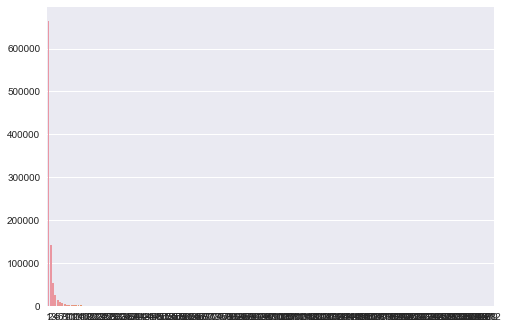

In [97]:
cumulative[0]
for key,value in customersDict.items():


In [91]:
customerNOfOrder

{1: 664020,
 2: 142429,
 3: 53828,
 4: 25964,
 5: 14490,
 6: 8967,
 7: 5846,
 8: 4015,
 9: 2978,
 10: 2097,
 11: 1715,
 12: 1283,
 13: 1053,
 14: 950,
 15: 766,
 16: 590,
 17: 525,
 18: 452,
 19: 385,
 20: 338,
 21: 290,
 22: 238,
 23: 207,
 24: 201,
 25: 188,
 26: 146,
 27: 133,
 28: 115,
 29: 87,
 30: 116,
 31: 89,
 32: 77,
 33: 81,
 34: 91,
 35: 58,
 36: 64,
 37: 45,
 38: 50,
 39: 50,
 40: 46,
 41: 44,
 42: 36,
 43: 38,
 44: 23,
 45: 27,
 46: 28,
 47: 23,
 48: 24,
 49: 22,
 50: 22,
 51: 19,
 52: 17,
 53: 15,
 54: 18,
 55: 18,
 56: 17,
 57: 14,
 58: 17,
 59: 13,
 60: 8,
 61: 12,
 62: 7,
 63: 12,
 64: 11,
 65: 14,
 66: 10,
 67: 13,
 68: 7,
 69: 10,
 70: 11,
 71: 5,
 72: 8,
 73: 6,
 74: 6,
 75: 5,
 76: 7,
 77: 3,
 78: 5,
 79: 5,
 80: 3,
 81: 5,
 82: 9,
 83: 7,
 84: 5,
 85: 4,
 86: 5,
 87: 7,
 88: 6,
 89: 7,
 90: 3,
 91: 5,
 92: 3,
 93: 5,
 94: 5,
 95: 3,
 96: 1,
 97: 4,
 99: 3,
 100: 1,
 101: 3,
 102: 3,
 103: 1,
 105: 1,
 106: 4,
 107: 3,
 108: 2,
 110: 2,
 111: 2,
 112: 3,
 113: 2,
 

In [88]:
print("The %d%% (%d/%d) of customers has bought only 1 product" % (len(customersWithOneOrder)/float(len(customersDict))*100,len(customersWithOneOrder),len(customersDict)))

The 70% (664020/935894) of customers has bought only 1 product


In [78]:
productsWithOneOrder = list()
for key,value in productDict.items():
    if(len(value)==1):
        productsWithOneOrder.append(key)

In [89]:
print("The %d%% (%d/%d) of products has been bought only once" % (len(productsWithOneOrder)/float(len(productDict))*100,len(productsWithOneOrder),len(productDict)))

The 0% (0/58618) of products has been bought only once


In [11]:
df.to_pickle("%sAmazonDataProject.pkl" % PATH_DATA)

In [12]:
df_no_text = (df.drop(labels=["review_headline","review_body"],axis=1))

In [13]:
df_no_text.to_pickle("%sAmazonDataProjectNoText.pkl" % PATH_DATA)

In [14]:
df_no_text.head()

,customer_id,product_id,product_title,product_category,star_rating,helpful_votes,total_votes,verified_purchase,review_date
review_id,,,,,,,,,
R2YVNBBMXD8KVJ,10349,B00MWK7BWG,My Favourite Faded Fantasy,Music,5,0,0,True,2014-12-29
R2K4BOL8MN1TTY,10629,B006CHML4I,Seiko 5 Men's Automatic Watch with Black Dial ...,Watches,4,0,0,True,2013-10-24
R3P40IEALROVCH,12136,B00IIFCJX0,Dexter Season 8,Digital_Video_Download,5,0,0,True,2014-05-09
R25XL1WWYRDLA9,12268,B000W7JWUA,The Settlers of Catan Board Game - discontinue...,Toys,5,0,0,True,2014-09-19
RVTVB9YDXSFYH,12677,B005JTAP4S,Peter: A Darkened Fairytale (Vol 1),Digital_Ebook_Purchase,5,12,12,False,2013-09-18


In [15]:
df_no_text.dtypes

customer_id                  object
product_id                   object
product_title                object
product_category             object
star_rating                   uint8
helpful_votes                uint16
total_votes                  uint16
verified_purchase              bool
review_date          datetime64[ns]
dtype: object